In [1]:
num_experiments = 10
observation_sizes = [100, 1000, 5000]
num_cv = 5

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist
from Environment import AvgEnvironment
from Policy import MultinomialPolicy
from ParameterSelector import ParameterSelector
# from kernel import Exponential, Gaussian, Linear, Polynomial, RationalQuadratic
from Estimator_CPME import *
import joblib
import os

2025-05-18 15:42:47.863182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747582967.888674 2231643 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747582967.896680 2231643 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747582967.916480 2231643 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747582967.916501 2231643 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747582967.916504 2231643 computation_placer.cc:177] computation placer alr

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
config = {
    "n_users": 50,
    "n_items": 20,
    "context_dim": 10,
    "n_reco": 4,
}

obs_size = 100
num_iter = 5

In [4]:
def simulate_observation_size(obs_size, config, num_iter):
    results = []

    # === Generate environment ===
    user_vectors = np.random.normal(0, 1, size=(config["n_users"], config["context_dim"]))
    target_user_vectors = user_vectors * np.random.binomial(1, 0.5, size=user_vectors.shape)
    item_vectors = np.random.normal(0, 1, size=(config["n_items"], config["context_dim"]))

    alpha = -0.3
    logging_user_vectors = alpha * target_user_vectors

    logging_policy = MultinomialPolicy(item_vectors, logging_user_vectors, config["n_items"], config["n_reco"], temperature=0.5, cal_gamma=True)
    target_policy = MultinomialPolicy(item_vectors, target_user_vectors, config["n_items"], config["n_reco"], temperature=1.0, cal_gamma=False)
    environment = AvgEnvironment(item_vectors, user_vectors)

    seeds = np.random.randint(np.iinfo(np.int32).max, size=num_iter)

    for seed in tqdm(seeds, desc=f"Obs size {obs_size}"):
        np.random.seed(seed)

        # === Generate simulation data ===
        sim_data = []
        for _ in range(obs_size):
            user = environment.get_context()

            logging_reco, logging_multinomial, logging_user_vector = logging_policy.recommend(user)
            target_reco, target_multinomial, _ = target_policy.recommend(user)

            sim_data.append({
                "null_context_vec": logging_user_vector,
                "target_context_vec": logging_user_vector,
                "null_reco": tuple(logging_reco),
                "null_reco_vec": np.concatenate(item_vectors[logging_reco]),
                "null_reward": environment.get_reward(user, logging_reco),
                "target_reco": tuple(target_reco),
                "target_multinomial": target_multinomial,
                "target_reco_vec": np.concatenate(item_vectors[target_reco]),
                "target_reward": environment.get_reward(user, target_reco),
                "null_multinomial": logging_multinomial,
                "user": user,
            })

        sim_data = pd.DataFrame(sim_data)

        # === Prepare estimators ===
        behavior_estimator = BehaviorPolicyEstimator(config["n_items"])
        user_features = np.vstack(sim_data["null_context_vec"].values)
        actions = [r[0] for r in sim_data["null_reco"].values]  # Taking first item as action

        behavior_estimator.fit(user_features, actions)

        estimators = [
            IPSEstimator(logging_policy, target_policy, null_propensity_known = True),
            DirectEstimator(),
            DoublyRobustEstimator(logging_policy, target_policy, null_propensity_known = True),
            # CMEstimator(rbf_kernel, rbf_kernel, params=[5e-5, 1.0, 1.0]),
            # DRCMEstimator(rbf_kernel, rbf_kernel, [1e-3, 1.0, 1.0], behavior_estimator, target_policy), 
            CMEbis(rbf_kernel, rbf_kernel, params=[5e-5, 1.0, 1.0]),
            DoublyRobustbis(rbf_kernel, rbf_kernel, [5e-5, 1.0, 1.0], logging_policy, target_policy, null_propensity_known = True)
        ]

        # parameter selection
        direct_selector = ParameterSelector(estimators[1])  # direct estimator
        params_grid = [(n_hiddens, 1024, 100) for n_hiddens in [50, 100, 150, 200]]
        direct_selector.select_from_propensity(sim_data, params_grid, logging_policy, target_policy)
        estimators[1] = direct_selector.estimator
        
        estimators[2].params = direct_selector.parameters  # doubly robust estimator
        
        cme_selector = ParameterSelector(estimators[3])  # cme estimator
        # params_grid = [[(10.0 ** p) / config['n_observation'], 1.0, 1.0] for p in np.arange(-7, 0, 1)]
        params_grid = [[(10.0 ** p), 1.0, 1.0] for p in np.arange(-7, 0, 1)]
        cme_selector.select_from_propensity(sim_data, params_grid, logging_policy, target_policy)
        estimators[3] = cme_selector.estimator
        
        estimators[4].params = estimators[3]._params
        # === Prepare features for reward estimators ===
        logging_context_vec = np.vstack(sim_data["null_context_vec"].dropna().values)
        logging_reco_vec = np.vstack(sim_data["null_reco_vec"].dropna().values)
        logging_reward = sim_data["null_reward"].dropna().values

        X_logging = np.hstack([logging_context_vec, logging_reco_vec])

        # === Train reward models where needed ===
        for estimator in estimators:
            if isinstance(estimator, DirectEstimator):
                estimator.fit(X_logging, logging_reward, n_hidden_units=estimator.params[0], batch_size=1024, epochs=100)
            if isinstance(estimator, DoublyRobustEstimator):
                estimator.fit(X_logging, logging_reward)

        # === Calculate results ===
        actual_value = np.mean(sim_data["target_reward"])

        for estimator in estimators:
            est_value = estimator.estimate(sim_data)
            mse = (est_value - actual_value) ** 2
            results.append({
                "Estimator": estimator.name,
                "MSE": mse,
                "Observation Size": obs_size
            })

    return pd.DataFrame(results)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


2025-05-18 15:56:41.543965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-18 15:56:41.544140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747583801.588281 2233702 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747583801.588262 2233703 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747583801.602043 2233703 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1747583801.602049 2233702 cuda_blas.cc:1

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   50.2s
[Paralle

Obs size 100:   0%|          | 0/5 [00:00<?, ?it/s]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747583933.011685 2231643 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1109 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:84:00.0, compute capability: 8.6
I0000 00:00:1747583935.032446 223

/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Obs size 100:  20%|██        | 1/5 [01:11<04:45, 71.29s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Obs size 100:  40%|████      | 2/5 [02:17<03:24, 68.08s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Obs size 100:  60%|██████    | 3/5 [03:22<02:13, 66.91s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Obs size 100:  80%|████████  | 4/5 [04:29<01:06, 66.90s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Obs size 100: 100%|██████████| 5/5 [05:34<00:00, 66.93s/it]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



2025-05-18 16:04:27.436695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-18 16:04:27.436765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747584267.480319 2257366 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747584267.480263 2257365 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747584267.493700 2257365 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1747584267.493866 2257366 cuda_blas.cc:

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   50.2s
[Paralle

Obs size 1000:   0%|          | 0/5 [00:00<?, ?it/s]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Obs size 1000:  20%|██        | 1/5 [01:13<04:55, 73.89s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` objec

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Obs size 1000:  40%|████      | 2/5 [02:27<03:40, 73.48s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` objec

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Obs size 1000:  60%|██████    | 3/5 [03:42<02:28, 74.46s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` objec

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Obs size 1000:  80%|████████  | 4/5 [04:58<01:14, 74.85s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` objec

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Obs size 1000: 100%|██████████| 5/5 [06:14<00:00, 74.81s/it]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



2025-05-18 16:12:52.672698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-18 16:12:52.673426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747584772.716719 2281104 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747584772.718474 2281103 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747584772.730271 2281104 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1747584772.732508 2281103 cuda_blas.cc:

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   51.0s
[Paralle

Obs size 5000:   0%|          | 0/5 [00:00<?, ?it/s]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Obs size 5000:  20%|██        | 1/5 [04:22<17:30, 262.58s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` obje

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Obs size 5000:  40%|████      | 2/5 [08:47<13:11, 263.93s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` obje

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Obs size 5000:  60%|██████    | 3/5 [13:08<08:45, 262.72s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` obje

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Obs size 5000:  80%|████████  | 4/5 [17:31<04:22, 262.75s/it]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` obje

PARAMETER SELECTION IS DONE!
PARAMETER SELECTION IS DONE!


/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Obs size 5000: 100%|██████████| 5/5 [21:55<00:00, 263.12s/it]


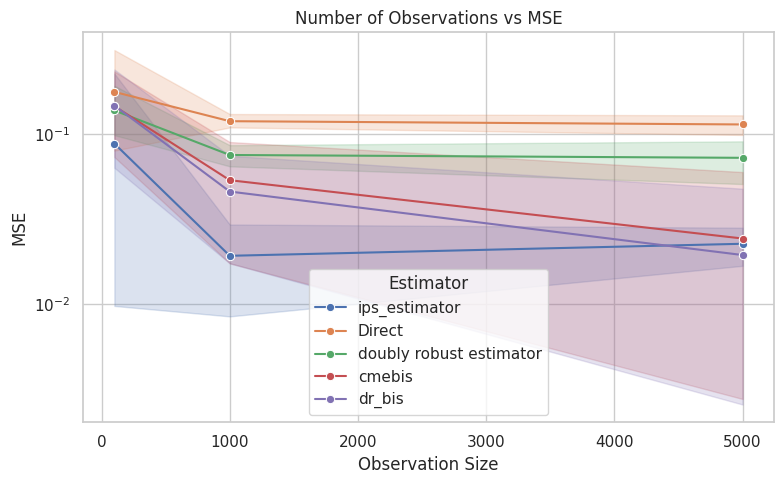

In [6]:

# Running the simulation
full_results = pd.concat(
    [simulate_observation_size(n, config, num_iter) for n in observation_sizes]
)

# full_results = joblib.Parallel(n_jobs=-1, verbose=0)(
#             joblib.delayed(simulate_observation_size)(n, config, num_iter) for n in observation_sizes
#         )
# Plotting results

import os
if not os.path.exists("./Results"):
    os.mkdir("./Results")

full_results.to_csv("Results/OPE_n_observations_result.csv", index=False)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=full_results, x="Observation Size", y="MSE", hue="Estimator", marker="o"
)
plt.yscale("log")
plt.title("Number of Observations vs MSE")
plt.tight_layout()
plt.show()

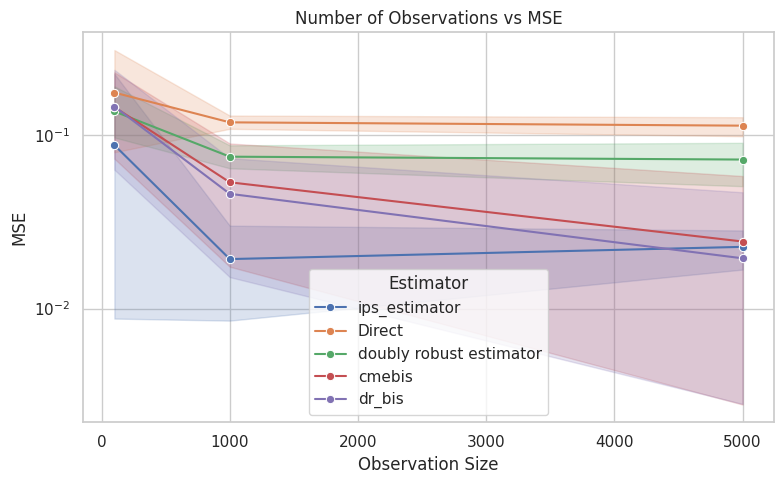

In [8]:
# Plotting results
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=full_results[(full_results.Estimator != 'dr_cme_estimator')], x="Observation Size", y="MSE", hue="Estimator", marker="o"
)
plt.yscale("log")
plt.title("Number of Observations vs MSE")
plt.tight_layout()
plt.show()

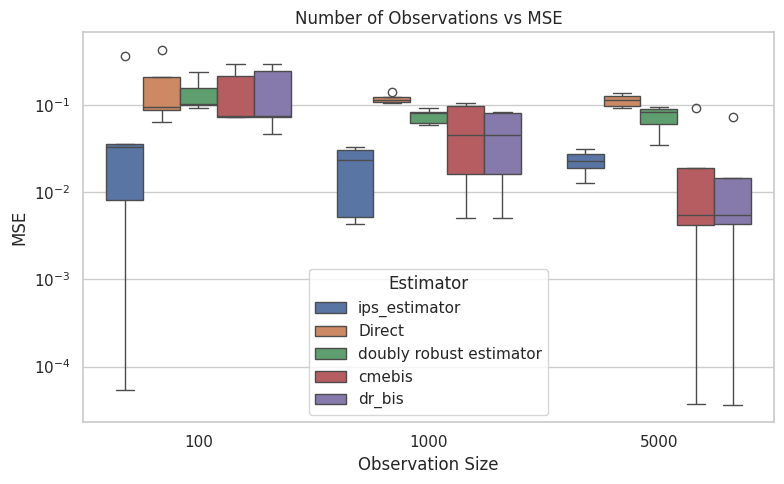

In [10]:
# Plotting results
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=full_results[(full_results.Estimator != 'dr_cme_estimator')], x="Observation Size", y="MSE", hue="Estimator", 
    # marker="o"
)
plt.yscale("log")
plt.title("Number of Observations vs MSE")
plt.tight_layout()
plt.show()

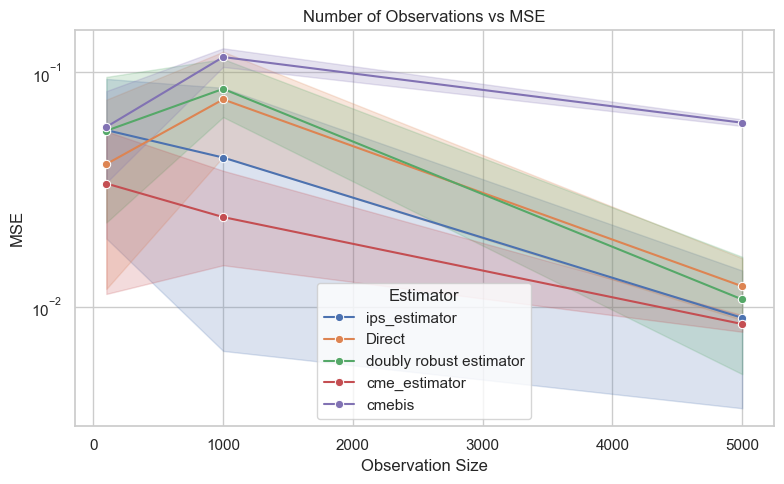

In [125]:
# Plotting results
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=full_results[(full_results.Estimator != 'dr_cme_estimator') & (full_results.Estimator != 'dr_bis')], x="Observation Size", y="MSE", hue="Estimator", marker="o"
)
plt.yscale("log")
plt.title("Number of Observations vs MSE")
plt.tight_layout()
plt.show()

In [128]:
full_results[(full_results.Estimator == 'cmebis') | (full_results.Estimator == 'dr_bis')]

,Estimator,MSE,Observation Size
5,cmebis,0.029216,100
6,dr_bis,0.029213,100
12,cmebis,0.081722,100
13,dr_bis,0.081724,100
19,cmebis,0.059683,100
20,dr_bis,0.059680,100
26,cmebis,0.025558,100
27,dr_bis,0.025558,100
33,cmebis,0.096179,100
34,dr_bis,0.096178,100


In [65]:
import jax.numpy as jnp
import numpy as np

from kernel import Exponential, Gaussian, Linear, Polynomial, RationalQuadratic

settings = {"reg_lambda": 1e-5, "bandwidth": 1}


def _get_kernel(settings):
    if settings["kernel"] == "gauss":
        kernel = Gaussian(settings)
        return kernel
    elif settings["kernel"] == "exp":
        kernel = Exponential(settings)
        return kernel
    elif settings["kernel"] == "linear":
        return Linear(settings)
    elif settings["kernel"] == "polynomial":
        return Polynomial(settings)
    elif settings["kernel"] == "rq":
        return RationalQuadratic(settings)
    else:
        raise NotImplementedError

# === Generate simulation data ===
user_vectors = np.random.normal(0, 1, size=(config["n_users"], config["context_dim"]))
target_user_vectors = user_vectors * np.random.binomial(1, 0.5, size=user_vectors.shape)
item_vectors = np.random.normal(0, 1, size=(config["n_items"], config["context_dim"]))

alpha = -0.3
logging_user_vectors = alpha * target_user_vectors

logging_policy = MultinomialPolicy(item_vectors, logging_user_vectors, config["n_items"], config["n_reco"], temperature=0.5, cal_gamma=True)
target_policy = MultinomialPolicy(item_vectors, target_user_vectors, config["n_items"], config["n_reco"], temperature=1.0, cal_gamma=False)
environment = AvgEnvironment(item_vectors, user_vectors)

sim_data = []
for _ in range(obs_size):
        user = environment.get_context()

        logging_reco, logging_multinomial, logging_user_vector = logging_policy.recommend(user)
        target_reco, target_multinomial, _ = target_policy.recommend(user)

        sim_data.append({
        "logging_context_vec": logging_user_vector,
        "target_context_vec": logging_user_vector,
        "logging_reco": tuple(logging_reco),
        "logging_reco_vec": np.concatenate(item_vectors[logging_reco]),
        "logging_reward": environment.get_reward(user, logging_reco),
        "target_reco": tuple(target_reco),
        "target_multinomial": target_multinomial,
        "target_reco_vec": np.concatenate(item_vectors[target_reco]),
        "target_reward": environment.get_reward(user, target_reco),
        "logging_multinomial": logging_multinomial,
        "user": user,
        })

sim_data = pd.DataFrame(sim_data)





[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    6.6s remaining:   26.3s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    6.7s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    6.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.9s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    6.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.0s finished


In [66]:
sim_data

,logging_context_vec,target_context_vec,logging_reco,logging_reco_vec,logging_reward,target_reco,target_multinomial,target_reco_vec,target_reward,logging_multinomial,user
0,"[0.0, -0.0, -0.0, -0.0, 0.0]","[0.0, -0.0, -0.0, -0.0, 0.0]","(1, 8, 9, 12)","[-0.4358349834913552, 1.0254555700768233, -0.0...",0,"(14, 4, 1, 10)","[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","[-0.9256260367226805, -0.007830870008659103, 0...",1,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",3
1,"[0.21360987207871576, -0.10427410231936293, -0...","[0.21360987207871576, -0.10427410231936293, -0...","(12, 10, 7, 0)","[-0.19738179424941676, 1.671202072272812, 0.52...",0,"(10, 14, 18, 4)","[0.01928113420032203, 0.044598081638489266, 0....","[-1.1302463306404904, 1.792649223582581, 1.797...",1,"[0.05113150968816029, 0.04508801081519802, 0.0...",4
2,"[0.4198860787048842, -0.6548985850854564, 0.0,...","[0.4198860787048842, -0.6548985850854564, 0.0,...","(18, 12, 9, 14)","[0.8033827292065501, -0.8485841276216847, -1.3...",1,"(12, 1, 10, 3)","[0.006937848492731827, 0.0874633618800129, 3.9...","[-0.19738179424941676, 1.671202072272812, 0.52...",1,"[0.03087421454560486, 0.02111084973576335, 0.0...",6
3,"[0.7336180622814856, -0.0, 0.13477225277999974...","[0.7336180622814856, -0.0, 0.13477225277999974...","(15, 18, 8, 10)","[1.2453069458345865, -1.808832351576569, -0.41...",0,"(6, 14, 4, 19)","[0.0010365064283952786, 0.012724991417509159, ...","[-0.08561691521998496, -2.432704795533552, 1.1...",1,"[0.059601532697458603, 0.040916135046917206, 0...",2
4,"[0.0, -0.0, 0.0, 0.13965533269395988, -0.0]","[0.0, -0.0, 0.0, 0.13965533269395988, -0.0]","(9, 0, 1, 5)","[0.3243135942096038, -0.534208083105601, -2.02...",1,"(19, 1, 13, 17)","[0.08479518194694054, 0.05058248771086369, 0.0...","[-1.1321545545378595, 0.13894021470071974, -0....",0,"[0.045648771948166175, 0.04932700502439304, 0....",9
...,...,...,...,...,...,...,...,...,...,...,...
95,"[0.4198860787048842, -0.6548985850854564, 0.0,...","[0.4198860787048842, -0.6548985850854564, 0.0,...","(10, 4, 6, 8)","[-1.1302463306404904, 1.792649223582581, 1.797...",0,"(3, 10, 12, 1)","[0.006937848492731827, 0.0874633618800129, 3.9...","[0.971091487237171, 0.9379053443315658, 0.1426...",1,"[0.03087421454560486, 0.02111084973576335, 0.0...",6
96,"[0.0, -0.0, 0.0, 0.13965533269395988, -0.0]","[0.0, -0.0, 0.0, 0.13965533269395988, -0.0]","(9, 8, 15, 0)","[0.3243135942096038, -0.534208083105601, -2.02...",0,"(5, 4, 0, 11)","[0.08479518194694054, 0.05058248771086369, 0.0...","[0.20389014208127826, 0.19229645713387436, -1....",1,"[0.045648771948166175, 0.04932700502439304, 0....",9
97,"[0.0, -0.0, -0.0, -0.0, 0.0]","[0.0, -0.0, -0.0, -0.0, 0.0]","(13, 8, 19, 10)","[0.45511007858513264, -0.8853124209955955, -0....",1,"(7, 4, 16, 5)","[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","[0.3128786364001493, -0.15667751206607267, -0....",0,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",3
98,"[-0.0, 0.0, -0.05033205125250053, 0.0091219448...","[-0.0, 0.0, -0.05033205125250053, 0.0091219448...","(1, 18, 17, 13)","[-0.4358349834913552, 1.0254555700768233, -0.0...",1,"(8, 2, 10, 14)","[0.02600608757556106, 0.01146934361427036, 0.1...","[0.9342944225892453, -1.2239703760632892, -0.3...",1,"[0.04961203257006456, 0.05609413929572372, 0.0...",5


In [91]:
logging_context_vec = np.stack(
    sim_data["logging_context_vec"].dropna(axis=0).to_numpy()
)
logging_reco_vec = np.stack(
    sim_data["logging_reco_vec"].dropna(axis=0).to_numpy()
)
target_context_vec = np.stack(
    sim_data["target_context_vec"].dropna(axis=0).to_numpy()
)
target_reco_vec = np.stack(
    sim_data["target_reco_vec"].dropna(axis=0).to_numpy()
)
logging_reward = sim_data["logging_reward"].dropna(axis=0).values

target_reward = sim_data["target_reward"].dropna(axis=0).values

In [69]:
logging_context_vec.shape

(100, 5)

In [82]:
settings = {
    'reg_lambda': 0.1,
    'reg_lambda_tilde':0.01,
    'kernel': 'gauss',
    'bandwidth': 0.1,
}
reg_lambda = settings["reg_lambda"]
reg_lambda_1 = settings["reg_lambda_tilde"]

kernel_treatment = _get_kernel(settings)
kernel_covariates = _get_kernel(settings)

kernel_treatment.fit(logging_reco_vec)
kernel_covariates.fit(logging_context_vec)

K_T = kernel_treatment.gram_matrix(logging_reco_vec)
K_X = kernel_covariates.gram_matrix(logging_context_vec)

K_T_tilde = kernel_treatment.evaluate(logging_reco_vec, target_reco_vec)
K_X_tilde = kernel_covariates.evaluate(logging_context_vec, target_context_vec)

n = logging_context_vec.shape[0]
A_logging = np.multiply(K_X, K_T) + n * reg_lambda * np.eye(n)
b_logging = np.multiply(K_T_tilde, K_X_tilde)
inv_K_tilde_K =  np.linalg.solve(A_logging, b_logging)
np.mean(np.dot(logging_reward,inv_K_tilde_K))

In [85]:
K_T.shape, K_X.shape, K_T_tilde.shape, K_X_tilde.shape

((100, 100), (100, 100), (100, 100), (100, 100))

68.99219088443058

In [93]:
np.mean(logging_reward)

0.49

In [94]:
np.mean(target_reward)

0.67

In [ ]:



K_T_M_X = K_T * K_M * K_X + n * reg_lambda * jnp.eye(n)
K_T_X = K_T * K_X + n * reg_lambda_1 * jnp.eye(n)

def _kme_cross_conditional_mean_outcomes(d, d_prime, y, a, x):
    """
    Estimate the cross conditional mean outcome

    Parameters
    ----------
    y       array-like, shape (n_samples)
            outcome value for each unit, continuous

    t       array-like, shape (n_samples)
            treatment value for each unit, binary

    m       array-like, shape (n_samples)
            mediator value for each unit, here m is necessary binary and uni-
            dimensional

    x       array-like, shape (n_samples, n_features_covariates)
            covariates (potential confounders) values

    settings dictionary
            parameters for the kernel

    Returns
    -------
    mu_0m : array-like, shape (n_samples)
            conditional mean outcome for control group

    mu_1m : array-like, shape (n_samples)
            conditional mean outcome for treatment group

    psi_t0t0 : array-like, shape (n_samples)
            cross conditional mean outcome

    psi_t0t1 : array-like, shape (n_samples)
            cross conditional mean outcome

    psi_t1t0 : array-like, shape (n_samples)
            cross conditional mean outcome

    psi_t1t1 : array-like, shape (n_samples)
            cross conditional mean outcome
    """
    n = x.shape[0]

    reg_lambda = settings["reg_lambda"]
    reg_lambda_1 = settings["reg_lambda_tilde"]

    kernel_treatment = _get_kernel(settings)
    kernel_mediator = _get_kernel(settings)
    kernel_covariates = _get_kernel(settings)

    kernel_treatment.fit(t)
    kernel_mediator.fit(m)
    kernel_covariates.fit(x)

    K_T = kernel_treatment.gram_matrix(t)
    K_M = kernel_mediator.gram_matrix(m)
    K_X = kernel_covariates.gram_matrix(x)

    K_T_M_X = K_T * K_M * K_X + n * reg_lambda * jnp.eye(n)
    K_T_X = K_T * K_X + n * reg_lambda_1 * jnp.eye(n)

    inv_K_T_M_X = np.linalg.inv(K_T_M_X)
    inv_K_T_X = np.linalg.inv(K_T_X)

    K_M_inv_K_T_X = np.dot(K_M, inv_K_T_X)
    Y_inv_K_T_M_X = np.dot(y, inv_K_T_M_X)

    d = d * np.array([1])
    d_prime = d_prime * np.array([1])

    K_Td = kernel_treatment.evaluate(t, d)
    K_Td_prime = kernel_treatment.evaluate(t, d_prime)

    #
    half_d = np.dot(K_M_inv_K_T_X, K_Td * K_X) * K_X
    half_d_prime = np.dot(K_M_inv_K_T_X, K_Td_prime * K_X) * K_X

    # eta_tt
    psi_d_d = np.dot(Y_inv_K_T_M_X, K_Td * half_d)

    # eta_td
    psi_d_d_prime = np.dot(Y_inv_K_T_M_X, K_Td_prime * half_d)

    # eta_dt
    psi_d_prime_d = np.dot(Y_inv_K_T_M_X, K_Td * half_d_prime)

    # eta_dd
    psi_d_prime_d_prime = np.dot(Y_inv_K_T_M_X, K_Td_prime * half_d_prime)

    mu_d = np.dot(Y_inv_K_T_M_X, K_Td * K_M * K_X)
    mu_d_prime = np.dot(Y_inv_K_T_M_X, K_Td_prime * K_M * K_X)

    return mu_d, mu_d_prime, psi_d_d, psi_d_d_prime, psi_d_prime_d, psi_d_prime_d_prime


def _kme_conditional_mean_outcome(d, d_prime, y, t, m, x, settings):
    """
    Estimate the mediated response curve

    Parameters
    ----------
    y       array-like, shape (n_samples)
            outcome value for each unit, continuous

    t       array-like, shape (n_samples)
            treatment value for each unit, binary

    m       array-like, shape (n_samples)
            mediator value for each unit, here m is necessary binary and uni-
            dimensional

    x       array-like, shape (n_samples, n_features_covariates)
            covariates (potential confounders) values

    settings dictionary
            parameters for the kernel

    Returns
    -------
    eta_t0t0 : array-like, shape (n_samples)
            mediated response curve

    eta_t0t1 : array-like, shape (n_samples)
            mediated response curve

    eta_t1t0 : array-like, shape (n_samples)
            mediated response curve

    eta_t1t1 : array-like, shape (n_samples)
            mediated response curve
    """
    _, _, psi_d_d, psi_d_d_prime, psi_d_prime_d, psi_d_prime_d_prime = (
        _kme_cross_conditional_mean_outcomes(d, d_prime, y, t, m, x, settings)
    )

    # eta_t1t1
    eta_d_d = np.mean(psi_d_d)

    # eta_t1t0
    eta_d_d_prime = np.mean(psi_d_d_prime)

    # eta_t0t1
    eta_d_prime_d = np.mean(psi_d_prime_d)

    # eta_t0t0
    eta_d_prime_d_prime = np.mean(psi_d_prime_d_prime)

    return eta_d_d, eta_d_d_prime, eta_d_prime_d, eta_d_prime_d_prime